In [55]:
import tensorflow as tf

import keras
from keras import layers, datasets, metrics, optimizers

import numpy as np

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
LATENT_DIM = 10

In [ ]:
fashion_mnist = datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [113]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [114]:
inputs = layers.Input(shape=(28, 28))
Z = layers.Flatten()(inputs)
Z = layers.Dense(150, activation="relu")(Z)
Z = layers.Dense(100, activation="relu")(Z)
codings_mean = layers.Dense(LATENT_DIM)(Z)  # μ
codings_log_var = layers.Dense(LATENT_DIM)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

In [115]:
decoder_inputs = layers.Input(shape=[LATENT_DIM])
x = layers.Dense(100, activation="relu")(decoder_inputs)
x = layers.Dense(150, activation="relu")(x)
x = layers.Dense(28 * 28)(x)
outputs = layers.Reshape((28, 28))(x)
variational_decoder = keras.Model(inputs=decoder_inputs, outputs=outputs)

In [116]:
class VAELossLayer(layers.Layer):
    def __init__(self, beta=5.0, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.total_loss_tracker = metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def call(self, inputs, codings_mean, codings_log_var, reconstructions):
        # 1. Reconstruction Loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(inputs, reconstructions)
        )
        reconstruction_loss *= tf.cast(tf.reduce_prod(inputs.shape[1:]), tf.float32) # Scale for pixel-wise loss

        # 2. KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.square(codings_mean) - tf.exp(codings_log_var),
            axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss)  # Average over the batch

        # 3. Total VAE Loss
        total_loss = reconstruction_loss + self.beta * kl_loss

        # Add the total loss to the model
        self.add_loss(total_loss)

        # Add loss values to metrics for monitoring
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)

        return reconstructions
    
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
outputs = VAELossLayer()(inputs, codings_mean, codings_log_var, reconstructions)
variational_ae = keras.Model(inputs=inputs, outputs=outputs)

In [117]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, mode="min"
)

variational_ae.compile(optimizer=optimizers.Nadam())
history = variational_ae.fit(
    x_train, x_train, epochs=25, batch_size=128, validation_data=(x_test, x_test), callbacks=[early_stopping_cb]
)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - kl_loss: 1.2962 - loss: 309.5157 - reconstruction_loss: 303.0345 - total_loss: 309.5156 - val_kl_loss: 3.3052 - val_loss: 225.6144 - val_reconstruction_loss: 209.0094 - val_total_loss: 225.5356
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.4743 - loss: 226.9071 - reconstruction_loss: 209.5354 - total_loss: 226.9071 - val_kl_loss: 3.9026 - val_loss: 225.5572 - val_reconstruction_loss: 206.0875 - val_total_loss: 225.6004
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.4374 - loss: 227.5857 - reconstruction_loss: 205.3987 - total_loss: 227.5857 - val_kl_loss: 4.3524 - val_loss: 217.5971 - val_reconstruction_loss: 195.7603 - val_total_loss: 217.5226
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.6844 - loss: 222.2113 - reconstruction_loss: 198.7890 - total_loss: 222.2113 - val_kl_loss: 4.2705 - val_loss: 215.9227 - val_reconstruction_loss: 194.5005 - val_total_loss: 215.8531
Epoch 

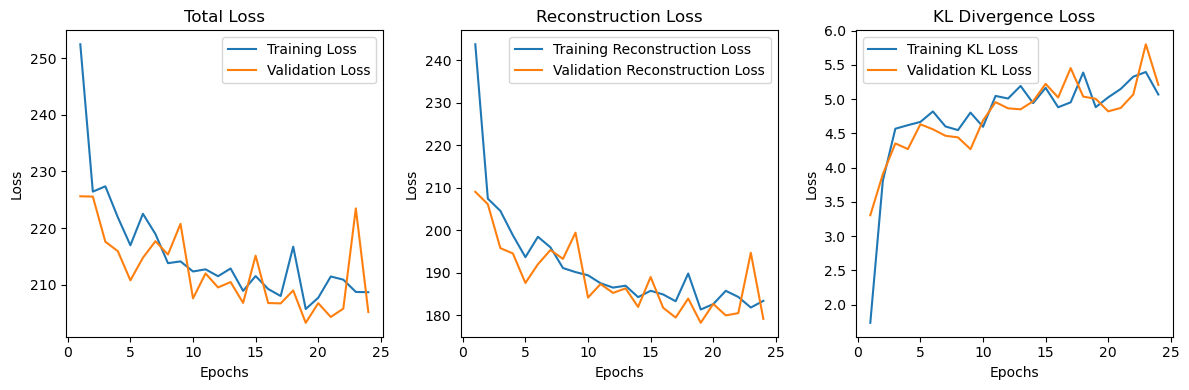

In [118]:
# Plotting the losses after training
total_loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']
val_loss = history.history.get('val_loss')
val_reconstruction_loss = history.history.get('val_reconstruction_loss')
val_kl_loss = history.history.get('val_kl_loss')

epochs_range = range(1, len(total_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, total_loss, label='Training Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, reconstruction_loss, label='Training Reconstruction Loss')
if val_reconstruction_loss:
    plt.plot(epochs_range, val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, kl_loss, label='Training KL Loss')
if val_kl_loss:
    plt.plot(epochs_range, val_kl_loss, label='Validation KL Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


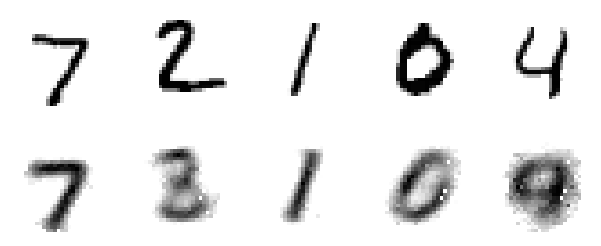

In [119]:
def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_ae, images=x_test)
plt.show()

In [120]:
codings = tf.random.normal(shape=[3 * 7, LATENT_DIM])
images = variational_decoder(codings).numpy()

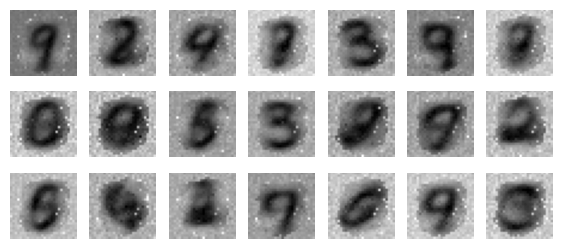

In [121]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

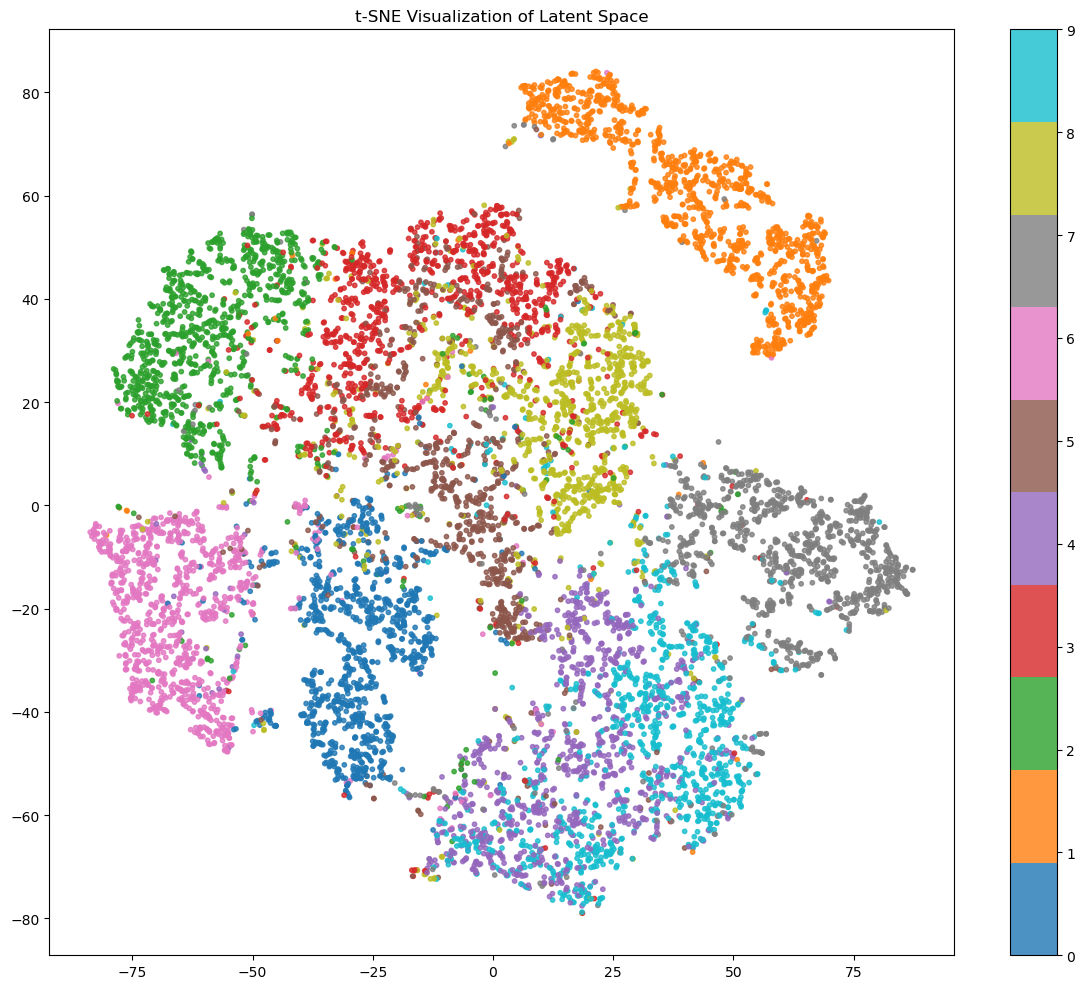

In [122]:
# Function for latent space exploration
# n_samples = 2000

# Sample random test points
# indices = np.random.choice(len(x_test), n_samples, replace=False)
samples = x_test#[indices]
labels = y_test#[indices]

# Encode to latent space
codings_mean, codings_log_var, codings = variational_encoder(samples)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
z_tsne = tsne.fit_transform(codings_mean)

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
            cmap='tab10', s=10, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of Latent Space")
plt.tight_layout()
plt.show()

In [123]:
variances = np.exp(codings_log_var.numpy())

average_variances = np.mean(variances, axis=0)

print("Average Variances per Latent Dimension:")
for i, avg_var in enumerate(average_variances):
    print(f"Dimension {i}: {avg_var:.4f}")

Average Variances per Latent Dimension:
Dimension 0: 0.3716
Dimension 1: 0.1546
Dimension 2: 0.8381
Dimension 3: 0.8674
Dimension 4: 0.8083
Dimension 5: 0.1617
Dimension 6: 0.4805
Dimension 7: 0.3021
Dimension 8: 0.9077
Dimension 9: 0.1241


In [124]:
threshold = 1e-3  # Adjust this threshold as needed
unused_dimensions = np.where(average_variances < threshold)[0]
print(f"\nPotentially Unused Dimensions (below threshold {threshold}): {unused_dimensions}")


Potentially Unused Dimensions (below threshold 0.001): []


In [125]:
# Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(codings_mean)

# Compute the ARI
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.4547393200447788


In [149]:
codings = np.zeros([7, LATENT_DIM])
codings[:, 9] = np.linspace(-0.8, 0.8, 7) 
images = variational_decoder(codings).numpy()

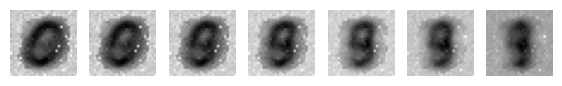

In [150]:
plot_multiple_images(images)
plt.show()